

Scenario 2:

2030: 50% switch
xxxxx
2040: 100% switch

Adds load during typical cooking times (morning, lunch, evening) with assumed per capita cooking demand pattern.

Assume daily_ecook_per_household = 2.06 in kWh
100 % EPC and hotplate


#daily cooking with 0.88–2.06 kilowatt hours (kWh) of electricity.
Under a “fuel-stacking scenario” (in which half the menu is cooked using an EPC and
the other half is cooked with another fuel), daily electricity consumption is projected to be just
0.30–0.67 kWh per household. from

Base Peak Load: 12645.10 MWh
New Peak Load (with e-cooking): 18339.35 MWh
Added Peak: 5694.25 MWh (45.03% increase)


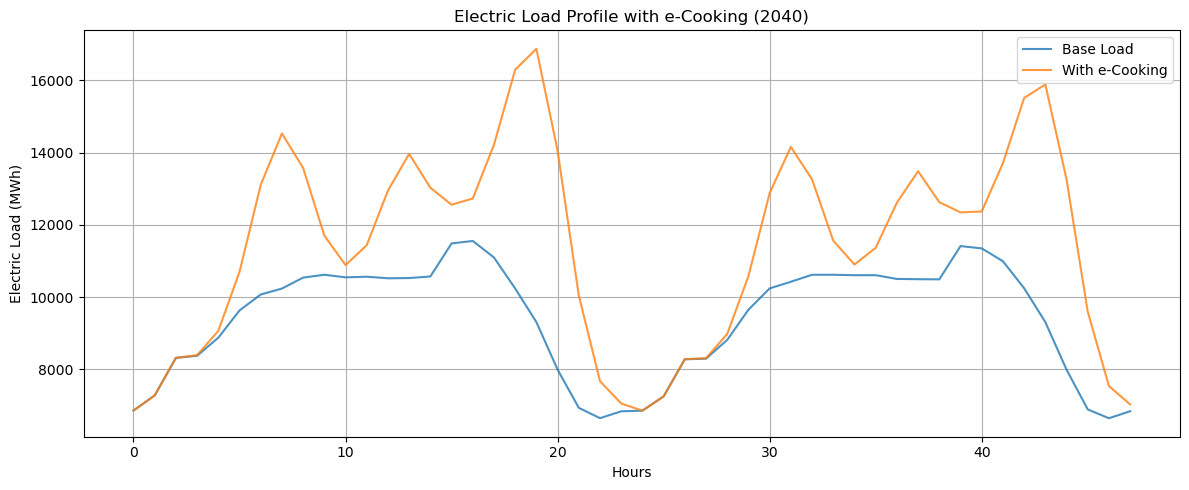

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT SECTION ===
input_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2040_base\era5_2013\Africa.csv"  
output_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2040_s2\era5_2013\Africa.csv"
year = 2040
population = 102279000
people_per_household = 4.2
daily_ecook_per_household = 2.06  # kWh per household per day
random_variation_scale = 0.10  # ±10%
days_in_year = 365  # Fixed for non-leap year
# ============================

# --- Load base demand (expecting 8760 rows for full year) ---
df = pd.read_csv(input_file, sep=";")
assert df.shape[0] == 8760, f"Expected 8760 hourly rows (365 days)"
# Strip whitespace from column names
#df.columns = df.columns.str.strip()

# Verify column names
#print(df.columns)

# Access the correct column
base_load_s2_2040 = df["Electricity demand"].values


# --- Generate time-of-day eCooking profile ---
def generate_weighted_cooking_profile():
    hours = np.arange(24)
    profile = np.zeros_like(hours, dtype=float)

    morning_frac = 0.25
    lunch_frac = 0.20
    dinner_frac = 0.55

    morning = np.exp(-0.5 * ((hours - 7) / 1.2) ** 2)
    morning /= morning.sum()
    morning *= morning_frac

    lunch = np.exp(-0.5 * ((hours - 13) / 1.2) ** 2)
    lunch /= lunch.sum()
    lunch *= lunch_frac

    dinner = np.exp(-0.5 * ((hours - 19) / 1.5) ** 2)
    dinner /= dinner.sum()
    dinner *= dinner_frac

    profile = morning + lunch + dinner
    return profile

# Expand profile over the year
daily_profile = generate_weighted_cooking_profile()
hourly_profile = np.tile(daily_profile, days_in_year)

# Add daily random variation
rng = np.random.default_rng(seed=42)
random_factors = rng.normal(loc=1.0, scale=random_variation_scale, size=days_in_year)
hourly_random = np.repeat(random_factors, 24)
randomized_profile = hourly_profile * hourly_random

# Total daily e-cooking load across population
households = population / people_per_household
total_ecook_daily = daily_ecook_per_household * households
hourly_ecook_load = total_ecook_daily * randomized_profile / 1000  # Convert kWh to MWh

# --- Combine base + e-cooking ---
total_load_s2_2040 = base_load_s2_2040 + hourly_ecook_load

# --- Save output ---

#df["Electricity demand"] = total_load_s2_2040
#df.to_csv(output_file, index=False)

# --- Peak Load Analysis ---
base_peak_s2_2040 = base_load_s2_2040.max()
new_peak_s2_2040 = total_load_s2_2040.max()
added_peak_s2_2040 = new_peak_s2_2040 - base_peak_s2_2040
percent_increase = (added_peak_s2_2040 / base_peak_s2_2040) * 100

print(f"Base Peak Load: {base_peak_s2_2040:.2f} MWh")
print(f"New Peak Load (with e-cooking): {new_peak_s2_2040:.2f} MWh")
print(f"Added Peak: {added_peak_s2_2040:.2f} MWh ({percent_increase:.2f}% increase)")

# --- Visualization (first 48 hours) ---
plt.figure(figsize=(12, 5))
plt.plot(base_load_s2_2040[:48], label="Base Load", alpha=0.8)
plt.plot(total_load_s2_2040[:48], label="With e-Cooking", alpha=0.8)
plt.xlabel("Hours")
plt.ylabel("Electric Load (MWh)")
plt.title(f"Electric Load Profile with e-Cooking ({year})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Base Peak Load: 4400.51 MWh
New Peak Load (with e-cooking): 6797.98 MWh
Added Peak: 2397.46 MWh (54.48% increase)


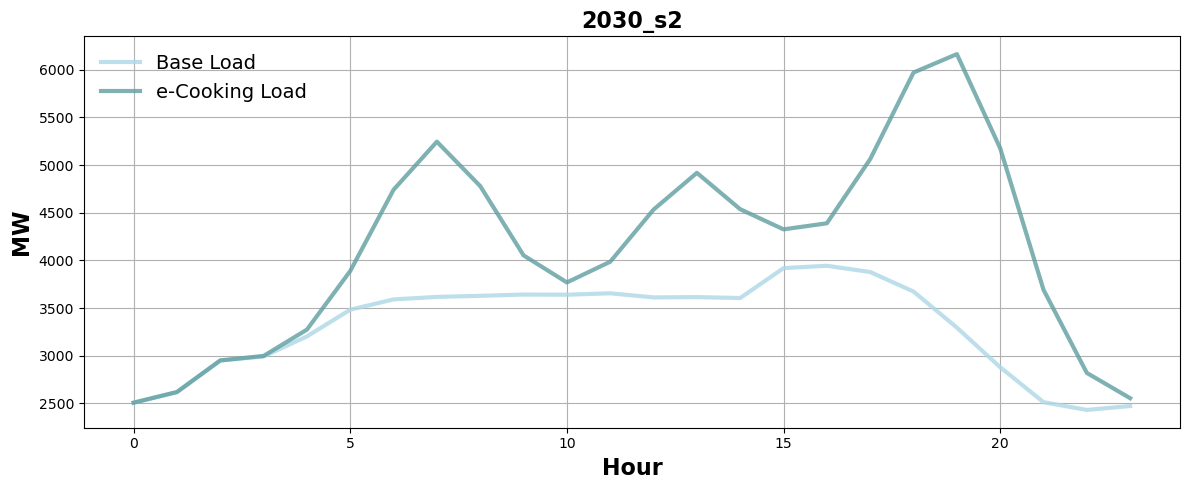

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT SECTION ===
input_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2030_base\era5_2013\Africa.csv"  
output_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2030_s2\era5_2013\Africa.csv"
year = 2030
population = 77537000 #
people_per_household = 4.2
daily_ecook_per_household = 1.03  # kWh per household per day
random_variation_scale = 0.10  # ±10%
days_in_year = 365  # Fixed for non-leap year
# ============================

# --- Load base demand (expecting 8760 rows for full year) ---
df = pd.read_csv(input_file, sep=";")
assert df.shape[0] == 8760, f"Expected 8760 hourly rows (365 days)"
# Strip whitespace from column names
#df.columns = df.columns.str.strip()

# Verify column names
#print(df.columns)

# Access the correct column
base_load_s2_2030 = df["Electricity demand"].values


# --- Generate time-of-day eCooking profile ---
def generate_weighted_cooking_profile():
    hours = np.arange(24)
    profile = np.zeros_like(hours, dtype=float)

    morning_frac = 0.25
    lunch_frac = 0.20
    dinner_frac = 0.55

    morning = np.exp(-0.5 * ((hours - 7) / 1.2) ** 2)
    morning /= morning.sum()
    morning *= morning_frac

    lunch = np.exp(-0.5 * ((hours - 13) / 1.2) ** 2)
    lunch /= lunch.sum()
    lunch *= lunch_frac

    dinner = np.exp(-0.5 * ((hours - 19) / 1.5) ** 2)
    dinner /= dinner.sum()
    dinner *= dinner_frac

    profile = morning + lunch + dinner
    return profile

# Expand profile over the year
daily_profile = generate_weighted_cooking_profile()
hourly_profile = np.tile(daily_profile, days_in_year)

# Add daily random variation
rng = np.random.default_rng(seed=42)
random_factors = rng.normal(loc=1.0, scale=random_variation_scale, size=days_in_year)
hourly_random = np.repeat(random_factors, 24)
randomized_profile = hourly_profile * hourly_random

# Total daily e-cooking load across population
households = population / people_per_household
total_ecook_daily = daily_ecook_per_household * households
hourly_ecook_load = total_ecook_daily * randomized_profile / 1000  # Convert kWh to MWh

# --- Combine base + e-cooking ---
total_load_s2_2030 = base_load_s2_2030 + hourly_ecook_load

# --- Save output ---

df["Electricity demand"] = total_load_s2_2030
#df.to_csv(output_file, index=False)
#print(f"Output saved to {output_file}")

# --- Peak Load Analysis ---
base_peak_s2_2030 = base_load_s2_2030.max()
new_peak_s2_2030 = total_load_s2_2030.max()
added_peak_s2_2030 = new_peak_s2_2030 - base_peak_s2_2030
percent_increase = (added_peak_s2_2030 / base_peak_s2_2030) * 100

print(f"Base Peak Load: {base_peak_s2_2030:.2f} MWh")
print(f"New Peak Load (with e-cooking): {new_peak_s2_2030:.2f} MWh")
print(f"Added Peak: {added_peak_s2_2030:.2f} MWh ({percent_increase:.2f}% increase)")

# --- Visualization (first 48 hours) ---
plt.figure(figsize=(12, 5))
plt.plot(base_load_s2_2030[0:24], label="Base Load", alpha=0.8, linewidth=3, color="lightblue")
plt.plot(total_load_s2_2030[0:24], label="e-Cooking Load", alpha=0.8,linewidth=3, color="cadetblue")
plt.xlabel("Hour",fontsize=16,fontweight='bold')
plt.ylabel("MW",fontsize=16,fontweight='bold')
plt.title(f"2030_s2", fontsize=16,fontweight='bold')
plt.legend(
    title="",
    title_fontsize=12,
    fontsize=14,
    loc="upper left",
    frameon=False,
    fancybox=True
)

plt.grid(True)
plt.tight_layout()
plt.show()



Demand profiles:
Scenario 1:

2030: 25% population switch to e-cooking

2040: 50% population switch to e-cooking (EPC) and rest is fuel stacking

Assume daily_ecook_per_household = 0.68 in kWh



Base Peak Load: 12645.10 MWh
New Peak Load (with e-cooking): 13230.21 MWh
Added Peak: 585.11 MWh (4.63% increase)


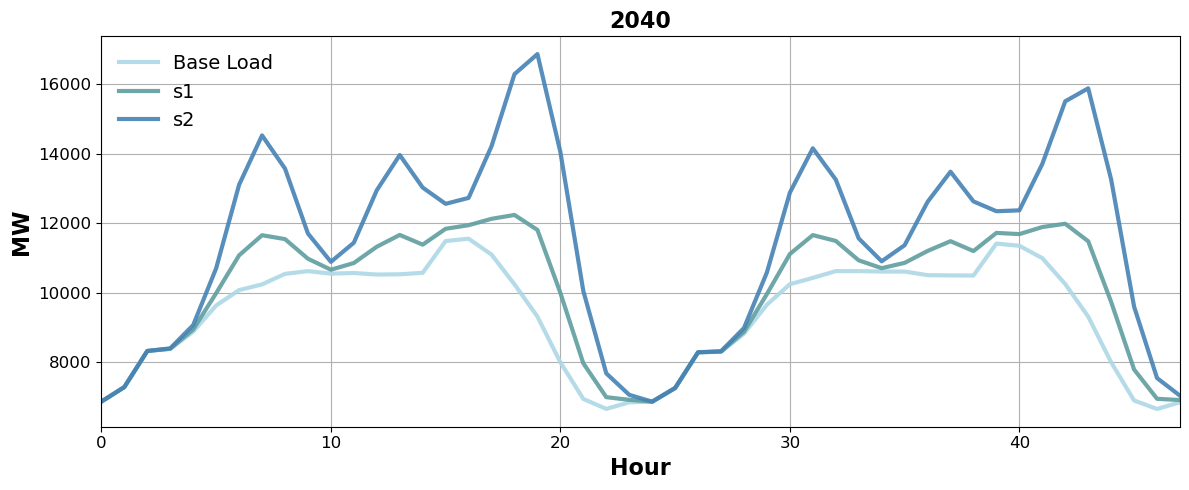

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER INPUT SECTION ===
input_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2040_base\era5_2013\Africa.csv"  
output_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2040_s1\era5_2013\Africa.csv"
year = 2040
population = 102279000
people_per_household = 4.2
daily_ecook_per_household = 0.68  # in kWh
random_variation_scale = 0.10  # ±10%
days_in_year = 365  # Fixed for non-leap year
# ============================

# --- Load base demand (expecting 8760 rows for full year) ---
df = pd.read_csv(input_file, sep=";")
assert df.shape[0] == 8760, f"Expected 8760 hourly rows (365 days)"
# Strip whitespace from column names
#df.columns = df.columns.str.strip()

# Verify column names
#print(df.columns)

# Access the correct column
base_load_s1_2040 = df["Electricity demand"].values


# --- Generate time-of-day eCooking profile ---
def generate_weighted_cooking_profile():
    hours = np.arange(24)
    profile = np.zeros_like(hours, dtype=float)

    morning_frac = 0.25
    lunch_frac = 0.20
    dinner_frac = 0.55

    morning = np.exp(-0.5 * ((hours - 7) / 1.2) ** 2)
    morning /= morning.sum()
    morning *= morning_frac

    lunch = np.exp(-0.5 * ((hours - 13) / 1.2) ** 2)
    lunch /= lunch.sum()
    lunch *= lunch_frac

    dinner = np.exp(-0.5 * ((hours - 19) / 1.5) ** 2)
    dinner /= dinner.sum()
    dinner *= dinner_frac

    profile = morning + lunch + dinner
    return profile

# Expand profile over the year
daily_profile = generate_weighted_cooking_profile()
hourly_profile = np.tile(daily_profile, days_in_year)

# Add daily random variation
rng = np.random.default_rng(seed=42)
random_factors = rng.normal(loc=1.0, scale=random_variation_scale, size=days_in_year)
hourly_random = np.repeat(random_factors, 24)
randomized_profile = hourly_profile * hourly_random

# Total daily e-cooking load across population
households = population / people_per_household
total_ecook_daily = daily_ecook_per_household * households
hourly_ecook_load = total_ecook_daily * randomized_profile / 1000  # Convert kWh to MWh

# --- Combine base + e-cooking ---
total_load_s1_2040= base_load_s1_2040 + hourly_ecook_load

# --- Save output ---

df["Electricity demand"] = total_load_s1_2040
#df.to_csv(output_file, index=False)
#print(f"Output saved to {output_file}")
# --- Peak Load Analysis ---
base_peak_s1_2040 = base_load_s1_2040.max()
new_peak_s1_2040 = total_load_s1_2040.max()
added_peak_s1_2040 = new_peak_s1_2040 - base_peak_s1_2040
percent_increase = (added_peak_s1_2040 / base_peak_s1_2040) * 100

print(f"Base Peak Load: {base_peak_s1_2040:.2f} MWh")
print(f"New Peak Load (with e-cooking): {new_peak_s1_2040:.2f} MWh")
print(f"Added Peak: {added_peak_s1_2040:.2f} MWh ({percent_increase:.2f}% increase)")


# --- Visualization (first 48 hours) ---
plt.figure(figsize=(12, 5))
plt.plot(base_load_s1_2040[0:48], label="Base Load", alpha=0.9, linewidth=3, color="lightblue")
plt.plot(total_load_s1_2040[0:48], label="s1", alpha=0.9,linewidth=3, color="cadetblue")
plt.plot(total_load_s2_2040[0:48], label="s2", alpha=0.9,linewidth=3, color="steelblue")
plt.xlabel("Hour",fontsize=16,fontweight='bold')
plt.ylabel("MW",fontsize=16,fontweight='bold')
plt.title(f"2040", fontsize=16,fontweight='bold')
plt.legend(
    title="",
    title_fontsize=12,
    fontsize=14,
    loc="upper left",
    frameon=False,
    fancybox=True
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,47)
plt.grid(True)
plt.tight_layout()
plt.show()



Base Peak Load: 4400.51 MW
New Peak Load (with e-cooking): 4723.08 MW
Added Peak: 322.57 MW (7.33% increase)


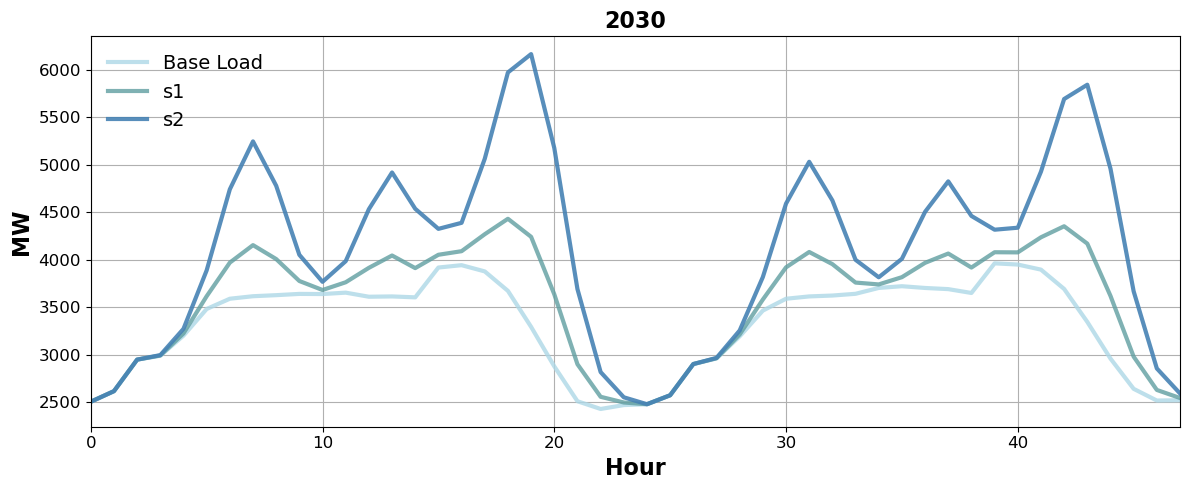

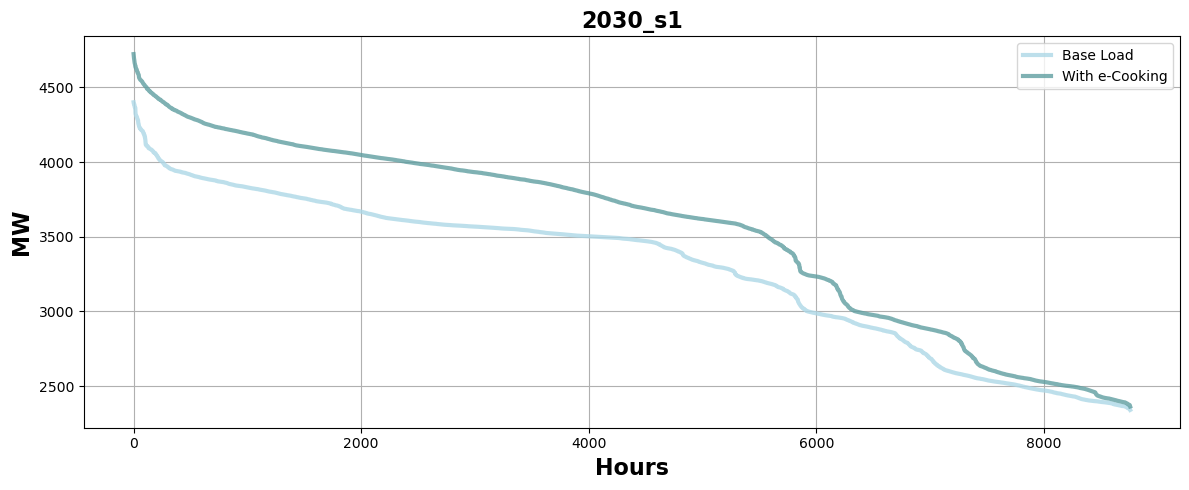

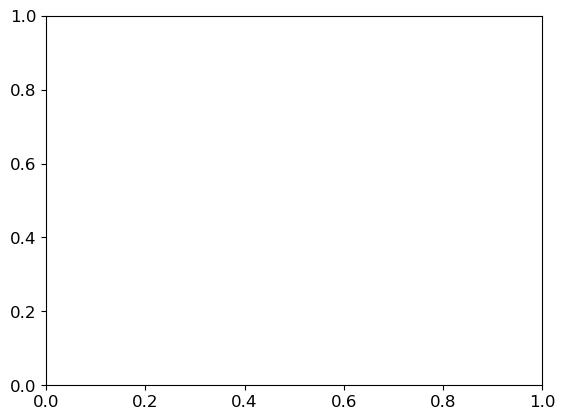

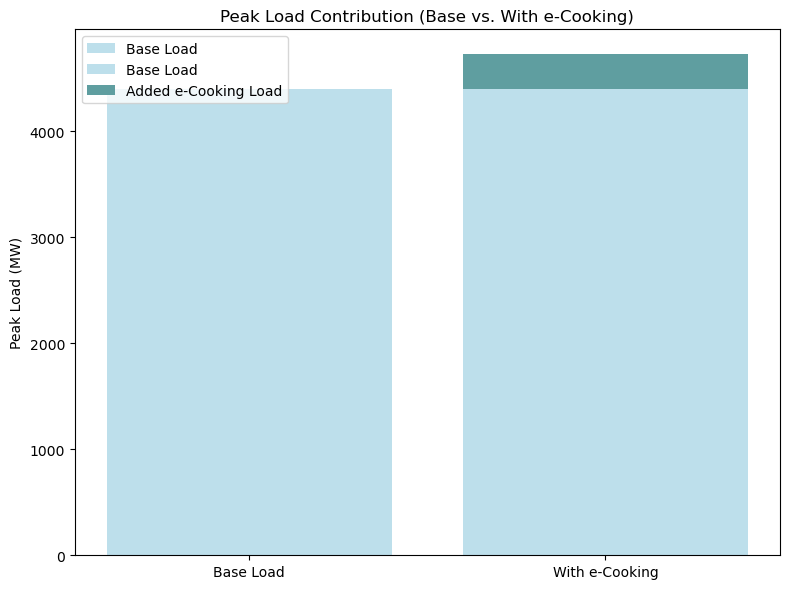

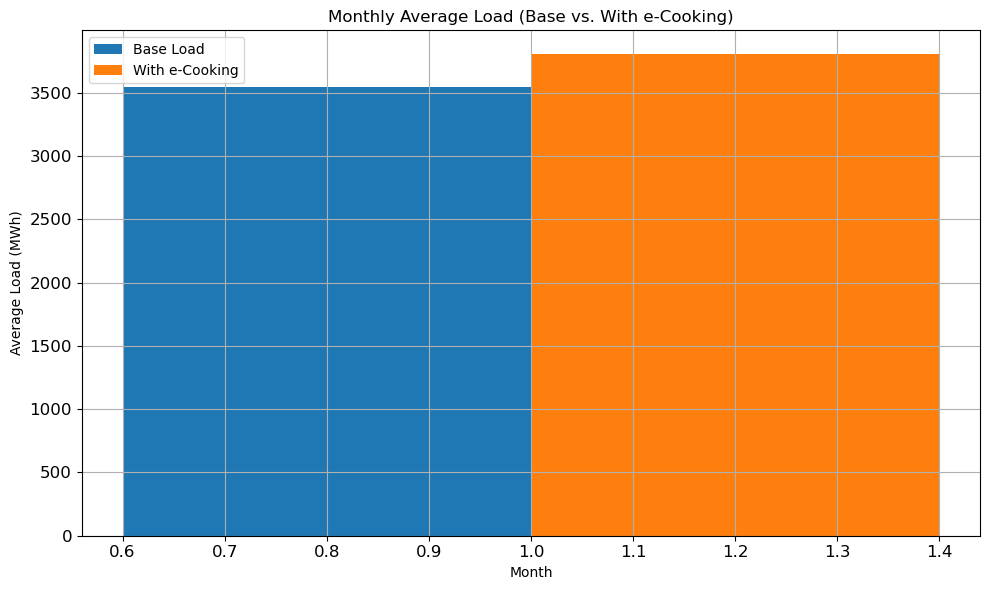

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === USER INPUT SECTION ===
input_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2030_base\era5_2013\Africa.csv"  
output_file = r"C:\Users\hie\pe_tan\pypsa-earth\data\ssp2-2.6\2030_s1\era5_2013\Africa.csv"
year = 2030
population = 77537000
people_per_household = 4.2
daily_ecook_per_household = 0.34  # in kWh
random_variation_scale = 0.10  # ±10%
days_in_year = 365  # Fixed for non-leap year
# ============================

# --- Load base demand (expecting 8760 rows for full year) ---
df = pd.read_csv(input_file, sep=";")
assert df.shape[0] == 8760, f"Expected 8760 hourly rows (365 days)"
# Strip whitespace from column names
#df.columns = df.columns.str.strip()

# Verify column names
#print(df.columns)

# Access the correct column
base_load_s1_2030 = df["Electricity demand"].values


# --- Generate time-of-day eCooking profile ---
def generate_weighted_cooking_profile():
    hours = np.arange(24)
    profile = np.zeros_like(hours, dtype=float)

    morning_frac = 0.25
    lunch_frac = 0.20
    dinner_frac = 0.55

    morning = np.exp(-0.5 * ((hours - 7) / 1.2) ** 2)
    morning /= morning.sum()
    morning *= morning_frac

    lunch = np.exp(-0.5 * ((hours - 13) / 1.2) ** 2)
    lunch /= lunch.sum()
    lunch *= lunch_frac

    dinner = np.exp(-0.5 * ((hours - 19) / 1.5) ** 2)
    dinner /= dinner.sum()
    dinner *= dinner_frac

    profile = morning + lunch + dinner
    return profile

# Expand profile over the year
daily_profile = generate_weighted_cooking_profile()
hourly_profile = np.tile(daily_profile, days_in_year)

# Add daily random variation
rng = np.random.default_rng(seed=42)
random_factors = rng.normal(loc=1.0, scale=random_variation_scale, size=days_in_year)
hourly_random = np.repeat(random_factors, 24)
randomized_profile = hourly_profile * hourly_random

# Total daily e-cooking load across population
households = population / people_per_household
total_ecook_daily = daily_ecook_per_household * households
hourly_ecook_load = total_ecook_daily * randomized_profile / 1000  # Convert kWh to MWh

# --- Combine base + e-cooking ---
total_load_s1_2030 = base_load_s1_2030 + hourly_ecook_load

# --- Save output ---

df["Electricity demand"] = total_load_s1_2030
#df.to_csv(output_file, index=False)
#print(f"Output saved to {output_file}")
# --- Peak Load Analysis ---
base_peak_s1_2030 = base_load_s1_2030.max()
new_peak_s1_2030 = total_load_s1_2030.max()
added_peak_s1_2030 = new_peak_s1_2030 - base_peak_s1_2030

percent_increase = (added_peak_s1_2030 / base_peak_s1_2030) * 100

print(f"Base Peak Load: {base_peak_s1_2030:.2f} MW")
print(f"New Peak Load (with e-cooking): {new_peak_s1_2030:.2f} MW")
print(f"Added Peak: {added_peak_s1_2030:.2f} MW ({percent_increase:.2f}% increase)")

start_time = "2013-01-01 00:00:00"  # Start of the desired range
end_time = "2013-01-01 23:00:00"

# --- Visualization (first 24 hours) ---
plt.figure(figsize=(12, 5))
plt.xlim(0, 47) 
plt.plot(base_load_s1_2030[0:48], label="Base Load", alpha=0.8, linewidth=3, color="lightblue")
plt.plot(total_load_s1_2030[0:48], label="s1", alpha=0.8, linewidth=3, color="cadetblue")
plt.plot(total_load_s2_2030[0:48], label="s2", alpha=0.9,linewidth=3, color="steelblue")
plt.xlabel("Hour",fontsize=16,fontweight='bold')
plt.ylabel("MW",fontsize=16,fontweight='bold')
plt.title(f"2030", fontsize=16,fontweight='bold')
plt.legend(
    title="",
    title_fontsize=12,
    fontsize=14,
    loc="upper left",
    frameon=False,
    fancybox=True
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()


#annual duration curve
plt.figure(figsize=(12, 5))
plt.plot(np.sort(base_load_s1_2030)[::-1], label="Base Load", alpha=0.8, linewidth=3, color="lightblue")
plt.plot(np.sort(total_load_s1_2030)[::-1], label="With e-Cooking", alpha=0.8, linewidth=3, color="cadetblue")
plt.xlabel("Hours", fontsize=16,fontweight='bold')
plt.ylabel("MW", fontsize=16,fontweight='bold')
plt.title("2030_s1", fontsize=16,fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#peak load contribution

plt.figure(figsize=(8, 6))
plt.bar(["Base Load"], [base_peak_s1_2030], label="Base Load",color= "lightblue", alpha=0.8)
plt.bar(["With e-Cooking"], [base_peak_s1_2030], label="Base Load", color= "lightblue", alpha=0.8)
plt.bar(["With e-Cooking"], [added_peak_s1_2030], bottom=[base_peak_s1_2030], label="Added e-Cooking Load", color="cadetblue")
plt.ylabel("Peak Load (MW)")
plt.title("Peak Load Contribution (Base vs. With e-Cooking)")
plt.legend()
plt.tight_layout()
plt.show()


df['Month'] = pd.to_datetime(df.index).month
monthly_base = df.groupby('Month')['Electricity demand'].mean()
monthly_total = (df['Electricity demand'] + hourly_ecook_load).groupby(df['Month']).mean()

plt.figure(figsize=(10, 6))
plt.bar(monthly_base.index - 0.2, monthly_base, width=0.4, label="Base Load")
plt.bar(monthly_total.index + 0.2, monthly_total, width=0.4, label="With e-Cooking")
plt.xlabel("Month")
plt.ylabel("Average Load (MWh)")
plt.title("Monthly Average Load (Base vs. With e-Cooking)")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'hrs' is not defined

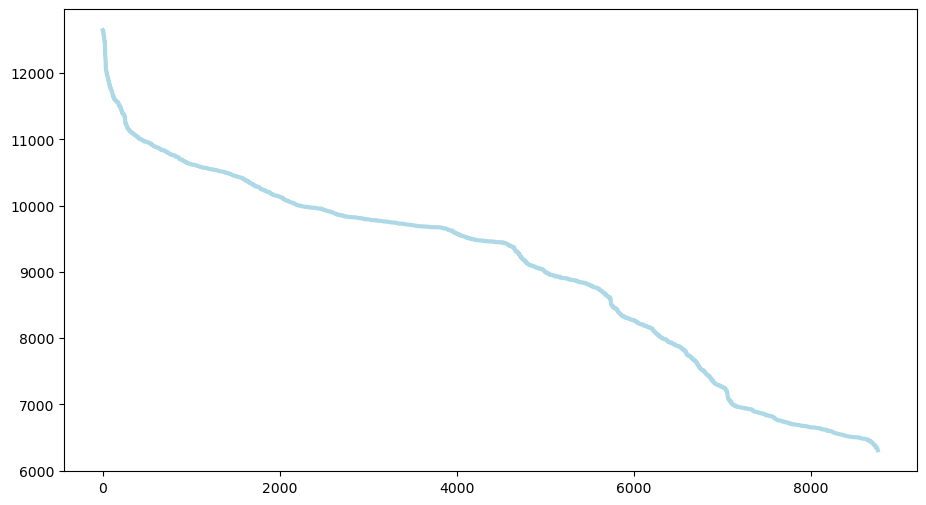

In [20]:
#compare scenarios 2030 and 2040
colors = {
    "Base": "lightblue",
    "s1 ": "cadetblue",
    "s2 ": '#8DB5AF'
}

#load duration curve
plt.figure(figsize=(11, 6))

scenarios = {"Base": base_load_s1_2040,"s1 ": total_load_s1_2040, "s2 ": total_load_s2_2040}
    for label, load in scenarios.items():
        # sort descending and build an x‐axis of hour ranks
        ld = np.sort(load)[::-1]
        hrs = np.arange(1, len(ld) + 1)

        # 1) the main curve
        plt.plot(hrs, ld, label=label, color=colors[label], linewidth=3)

        # 2) vertical “closing” line at the end of the curve
        plt.plot(
            [hrs[-1], hrs[-1]],      # x stays constant at last hour
            [ld[-1], 0],             # from last load down to zero
            color=colors[label],
            linestyle='--',
            linewidth=2
        )

plt.xlabel("Hours",fontsize=14,fontweight='bold')
plt.xlim(-20, 9000)
plt.ylabel("MW",fontsize=14,fontweight='bold')
plt.ylim(0,18500)
plt.title("2040",fontsize=16,fontweight='bold')
plt.legend(title="Scenario", title_fontsize=14,  fontsize=14, loc="upper right", frameon=True, fancybox=True)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 6))
scenarios = {"Base": base_load_s1_2030,"s1 ": total_load_s1_2030, "s2 ": total_load_s2_2030}
for label, load in scenarios.items():
    plt.plot(np.sort(load)[::-1], label=label, color=colors[label],linewidth=3)

plt.xlabel("Hours",fontsize=14)
plt.xlim(-30, 9000)  # Limit x-axis to 8760 hours
plt.ylabel("MW",fontsize=14)
plt.ylim(0, 7000)
plt.title("2030",fontsize=16,fontweight='bold')
plt.legend(title="Scenario",  title_fontsize=14, fontsize=14, loc="upper right", frameon=True, fancybox=True)
plt.grid(True)
plt.tight_layout()
plt.show()


#peak load contribution

plt.figure(figsize=(10, 6))

plt.bar(["2030_s1"], [base_peak_s1_2030], label="Base Load", color= "lightblue", alpha=0.6)
plt.bar(["2030_s1"], [added_peak_s1_2030], bottom=[base_peak_s1_2030], label="e-Cooking Load", color="cadetblue")
plt.bar(["2030_s2"], [base_peak_s2_2030], label="", color= "lightblue", alpha=0.6)
plt.bar(["2030_s2"], [added_peak_s2_2030], bottom=[base_peak_s2_2030], label="", color="cadetblue")
plt.bar(["2040_s1"], [base_peak_s1_2040], label="", color= "lightblue", alpha=0.6)
plt.bar(["2040_s1"], [added_peak_s1_2040], bottom=[base_peak_s1_2040], label="", color="cadetblue")
plt.bar(["2040_s2"], [base_peak_s2_2040], label="", color= "lightblue", alpha=0.6)
plt.bar(["2040_s2"], [added_peak_s2_2040], bottom=[base_peak_s2_2040], label="", color="cadetblue")
plt.ylabel("MW", fontsize=14,fontweight='bold')
plt.title("")
plt.legend(title="",  fontsize=14, loc="upper left", frameon=False, fancybox=True)
plt.tight_layout()
plt.show()


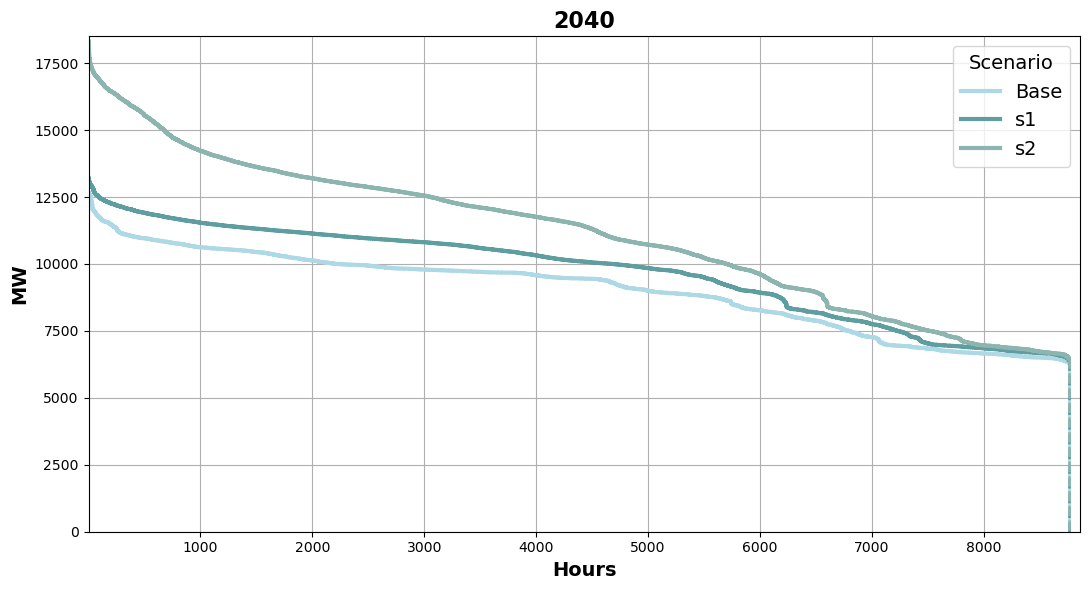

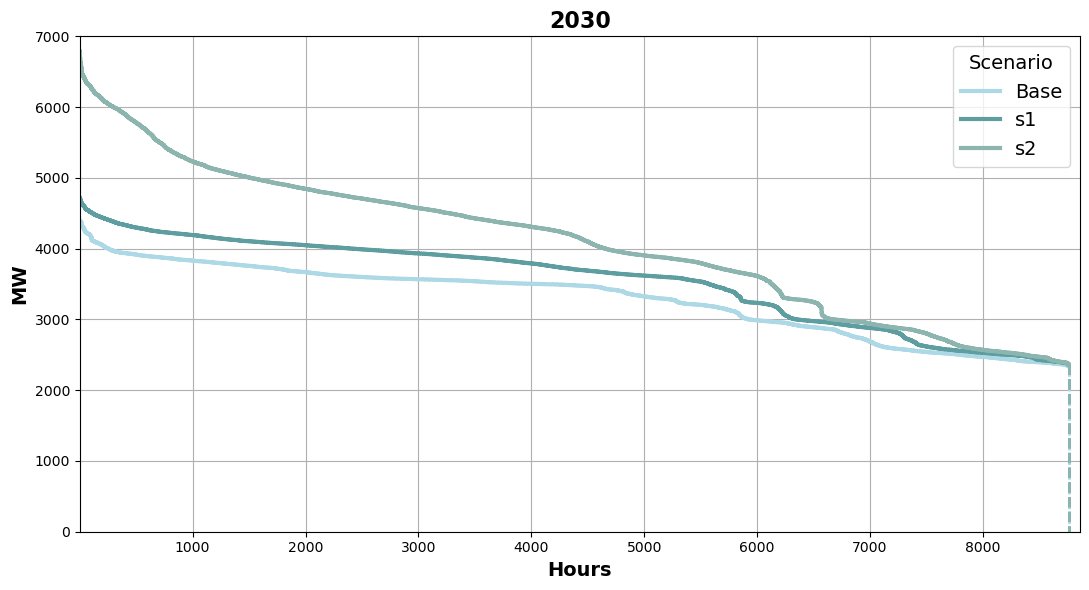

In [29]:
import numpy as np
import matplotlib.pyplot as plt

colors = {
    "Base": "lightblue",
    "s1":   "cadetblue",
    "s2":   "#8DB5AF"
}

def plot_ldc(scenarios, title, ylim):
    plt.figure(figsize=(11, 6))

    for label, load in scenarios.items():
        ld  = np.sort(load)[::-1]
        hrs = np.arange(1, len(ld) + 1)

        # main step‐plot curve
        plt.step(hrs, ld, where='post', label=label,
                 color=colors[label], linewidth=3)

        # vertical “closing” line
        plt.plot([hrs[-1], hrs[-1]], [ld[-1], 0],
                 color=colors[label], linestyle='--', linewidth=2)

    plt.xlabel("Hours", fontsize=14, fontweight='bold')
    plt.ylabel("MW", fontsize=14, fontweight='bold')
    plt.xlim(0.5, len(next(iter(scenarios.values()))) + 100)
    plt.ylim(0, ylim)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(title="Scenario", title_fontsize=14,
               fontsize=14, loc="upper right",
               frameon=True, fancybox=True)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# now the calls with matching dict keys:
plot_ldc(
    {"Base": base_load_s1_2040, "s1": total_load_s1_2040, "s2": total_load_s2_2040},
    title="2040",
    ylim=18500
)

plot_ldc(
    {"Base": base_load_s1_2030, "s1": total_load_s1_2030, "s2": total_load_s2_2030},
    title="2030",
    ylim=7000
)


KeyError: 's1'

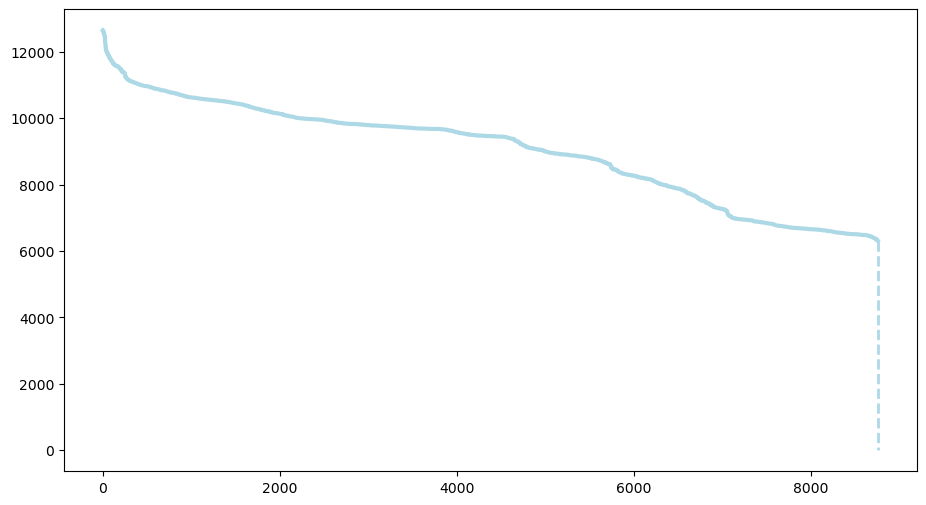

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#compare scenarios 2030 and 2040
colors = {
    "Base": "lightblue",
    "s1 ": "cadetblue",
    "s2 ": '#8DB5AF'
}

def plot_ldc(scenarios, title, ylim):
    plt.figure(figsize=(11, 6))

    for label, load in scenarios.items():
        # sort descending and build an x‐axis of hour ranks
        ld = np.sort(load)[::-1]
        hrs = np.arange(1, len(ld) + 1)

        # 1) the main curve
        plt.plot(hrs, ld, label=label, color=colors[label], linewidth=3)

        # 2) vertical “closing” line at the end of the curve
        plt.plot(
            [hrs[-1], hrs[-1]],      # x stays constant at last hour
            [ld[-1], 0],             # from last load down to zero
            color=colors[label],
            linestyle='--',
            linewidth=2
        )

    plt.xlabel("Hour rank", fontsize=14, fontweight='bold')
    plt.ylabel("MW", fontsize=14, fontweight='bold')
    plt.xlim(0, len(next(iter(scenarios.values()))) + 50)  # a little padding
    plt.ylim(0, ylim)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(title="Scenario", title_fontsize=14, fontsize=14,
               loc="upper right", frameon=True, fancybox=True)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 2040 plot
plot_ldc(
    {"Base": base_load_s1_2040, "s1": total_load_s1_2040, "s2": total_load_s2_2040},
    title="2040 Load Duration Curve",
    ylim=18500
)

# 2030 plot
plot_ldc(
    {"Base": base_load_s1_2030, "s1": total_load_s1_2030, "s2": total_load_s2_2030},
    title="2030 Load Duration Curve",
    ylim=7000
)


Superseeded:

In [ ]:
# import pandas as pd
# import numpy as np

# #files
# demand_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv"
# bus_region_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/buses_with_regions.csv"
# population_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/matched_population_by_region.csv"

# # Load baseline demand
# df_demand = pd.read_csv(demand_file, parse_dates=["time"])
# df_demand.set_index("time", inplace=True)

# # Load mapping and population
# bus_region = pd.read_csv(bus_region_file)
# pop_by_region = pd.read_csv(population_file)

# # Merge to assign population to buses
# bus_region = bus_region.merge(pop_by_region, on="Region")

# # Count buses per region
# bus_counts = bus_region.groupby("Region")["Bus"].count()

# # Compute population per bus
# bus_region["pop_per_bus"] = bus_region.apply(
#     lambda row: row["Population"] / bus_counts[row["Region"]], axis=1
# )

# # National population targets
# pop_2030 = 79837087
# pop_2040 = 102778984
# bus_region["weight_2030"] = bus_region["pop_per_bus"] * (pop_2030 / bus_region["pop_per_bus"].sum())
# bus_region["weight_2040"] = bus_region["pop_per_bus"] * (pop_2040 / bus_region["pop_per_bus"].sum())

# # E-cooking peak per household by adoption level
# ecook_peak_by_adoption = {
#     0.2: (16.07 * 0.9001) / 108,
#     0.5: (33.89 * 0.9530) / 108,
#     1.0: (67.29 * 0.9764) / 108
# }

# # Cooking hours profile
# cooking_profile = {
#     'morning': {'hours': [5, 6, 7, 8], 'fraction': 0.35},
#     'lunch': {'hours': [11, 12, 13, 14], 'fraction': 0.20},
#     'evening': {'hours': [17, 18, 19, 20], 'fraction': 0.45}
# }

# persons_per_hh = 4.6

# def generate_adjusted_profile(year, adoption_rate):
#     pop_col = "weight_2030" if year == 2030 else "weight_2040"
#     total_households = bus_region[pop_col].sum() / persons_per_hh
#     peak_kw_per_hh = ecook_peak_by_adoption[adoption_rate]
#     total_peak_kw = total_households * adoption_rate * peak_kw_per_hh

#     added_load = pd.Series(0.0, index=df_demand.index)

#     # Add cooking load to relevant hours
#     for period, val in cooking_profile.items():
#         for hour in val["hours"]:
#             mask = added_load.index.hour == hour
#             added_load[mask] += total_peak_kw * val["fraction"] / len(val["hours"])

#     # Apply only to buses that exist in both files
#     valid_buses = [str(b) for b in df_demand.columns]
#     adjusted_df = df_demand.copy()

#     for row in bus_region.itertuples():
#         bus = str(row.Bus)
#         if bus in valid_buses:
#             weight = getattr(row, pop_col)
#             share = weight / bus_region[pop_col].sum()
#             adjusted_df[bus] += added_load * share

#     return adjusted_df

# # Generate and store scenarios
# scenarios = {
#     "s1_2030": (2030, 0.2),
#     "s1_2040": (2040, 0.5),
#     "s2_2030": (2030, 0.5),
#     "s2_2040": (2040, 1.0),
# }

# output_previews = {}

# for name, (year, adoption) in scenarios.items():
#     df_adj = generate_adjusted_profile(year, adoption)
#     output_previews[name] = df_adj.copy()
#     df_adj.to_csv(f"C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_{name}.csv")

# output_previews["s1_2030"].iloc[0:24]  # Show first day as preview


Demand plots (aggregated for all buses)

In [ ]:
# import matplotlib.pyplot as plt

# # Load original (baseline) and one scenario for comparison
# baseline = df_demand.copy()
# scenario = pd.read_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv", parse_dates=['time']).set_index('time')



# # Load baseline demand and calculate total across all buses
# baseline = pd.read_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv", parse_dates=['time'])
# baseline.set_index('time', inplace=True)
# baseline_total = baseline.sum(axis=1)

# # Scenario files and labels
# scenario_paths = {
#     "s1_2030": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv",
#     "s1_2040": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2040.csv",
#     "s2_2030": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2030.csv",
#     "s2_2040": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2040.csv",
# }

# # Prepare plot
# plt.figure(figsize=(14, 8))
# plt.plot(baseline_total["2013-01-01":"2013-01-01 23:00:00"], label="Baseline", linestyle='--', color='black')

# # Plot each scenario
# for label, path in scenario_paths.items():
#     scenario = pd.read_csv(path, parse_dates=['time'])
#     scenario.set_index('time', inplace=True)
#     total_demand = scenario.sum(axis=1)
#     plt.plot(total_demand["2013-01-01":"2013-01-01 23:00:00"], label=label)

# # Formatting
# plt.title("Total National Demand (Baseline vs. E-Cooking Scenarios) on Jan 1, 2013", fontsize=14)
# plt.xlabel("Hour")
# plt.ylabel("Total Demand [kW]")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

Demand script using era5 (aggregated for the country)

In [ ]:
# import pandas as pd
# import numpy as np

# #files
# demand_file = "C:/Users/hie/pe_tan/pypsa-earth/data/ssp2-2.6/2030/era5_2013/Custom demand_TZ 2030.csv.csv"


# # Load baseline demand
# df_demand = pd.read_csv(demand_file, parse_dates=["time"])
# df_demand.set_index("time", inplace=True)
# df_demand=


# # National population targets
# pop_2030 = 79837087
# pop_2040 = 102778984
# bus_region["weight_2030"] = bus_region["pop_per_bus"] * (pop_2030 / bus_region["pop_per_bus"].sum())
# bus_region["weight_2040"] = bus_region["pop_per_bus"] * (pop_2040 / bus_region["pop_per_bus"].sum())

# # E-cooking peak per household by adoption level
# ecook_peak_by_adoption = {
#     0.2: (16.07 * 0.9001) / 108,
#     0.5: (33.89 * 0.9530) / 108,
#     1.0: (67.29 * 0.9764) / 108
# }

# # Cooking hours profile
# cooking_profile = {
#     'morning': {'hours': [5, 6, 7, 8], 'fraction': 0.35},
#     'lunch': {'hours': [11, 12, 13, 14], 'fraction': 0.20},
#     'evening': {'hours': [17, 18, 19, 20], 'fraction': 0.45}
# }

# persons_per_hh = 4.6

# def generate_adjusted_profile(year, adoption_rate):
#     pop_col = "weight_2030" if year == 2030 else "weight_2040"
#     total_households = bus_region[pop_col].sum() / persons_per_hh
#     peak_kw_per_hh = ecook_peak_by_adoption[adoption_rate]
#     total_peak_kw = total_households * adoption_rate * peak_kw_per_hh

#     added_load = pd.Series(0.0, index=df_demand.index)

#     # Add cooking load to relevant hours
#     for period, val in cooking_profile.items():
#         for hour in val["hours"]:
#             mask = added_load.index.hour == hour
#             added_load[mask] += total_peak_kw * val["fraction"] / len(val["hours"])

   

# # Generate and store scenarios
# scenarios = {
#     "s1_2030": (2030, 0.2),
#     "s1_2040": (2040, 0.5),
#     "s2_2030": (2030, 0.5),
#     "s2_2040": (2040, 1.0),
# }

# output_previews = {}

# for name, (year, adoption) in scenarios.items():
#     df_adj = generate_adjusted_profile(year, adoption)
#     output_previews[name] = df_adj.copy()
#     df_adj.to_csv(f"C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/era5_demand_{name}.csv")

# output_previews["s1_2030"].iloc[0:24]  # Show first day as preview


Baseline demand profile

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # File paths
# baseline_path = "demand_profiles - Copy.csv"

# # Load all demand profiles
# df_baseline = pd.read_csv(baseline_path, parse_dates=["time"]).set_index("time")

# # Filter for one day (e.g., 2013-01-01)
# df_baseline_one_day = df_baseline.loc["2013-01-01"]

# # Aggregate total hourly demand
# total_baseline = df_baseline_one_day.sum(axis=1)

# # Plotting
# plt.figure(figsize=(14, 6))
# plt.plot(total_baseline.index, total_baseline, label="Baseline", linestyle="--")

# plt.title("Total Hourly Demand Profiles for 2013-01-01")
# plt.xlabel("Time")
# plt.ylabel("Total Demand (MW)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Revised method using different ecooking input from "Modelling the Costs and Benefits of Modern Energy Cooking Services—Methods and Case Studies" NB! Normalized for 4.4 HH

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import datetime, timedelta


# # Create time index (hourly)
# time_index = [datetime(2023, 1, 1, h, 0) for h in range(24)]

# # eCooking profile: based on 10 households with partial (50%) eCooking using EPCs
# # Peak per household cooking load after diversity is 400W, which spans mainly around 3 meal windows.
# ecooking_profile_watts = np.array([
#     10, 10, 10, 10, 10, 20,    # 0-5
#     200, 300, 100, 50, 30, 20, # 6-11 (breakfast/morning cooking peak)
#     10, 10, 250, 300, 200, 100, # 12-17 (lunch/dinner ramp)
#     400, 300, 150, 50, 20, 10  # 18-23 (dinner peak tapering)
# ])
# ecooking_kwh = ecooking_profile_watts / 1000  # convert to kW (1-hour intervals)

# # Non-cooking loads (lighting + appliances), from Figure 11 pattern, simplified
# # Lighting: red line, generally stable and increasing after sunset
# # Appliances: blue line, morning and evening peak
# non_cooking_appliances = np.array([
#     50, 50, 50, 50, 50, 100,   # 0-5
#     300, 400, 300, 200, 150, 100,  # 6-11
#     100, 100, 150, 200, 300, 400,  # 12-17
#     500, 600, 400, 200, 100, 50   # 18-23
# ]) / 1000  # kWh

# non_cooking_lighting = np.array([
#     10, 10, 10, 10, 10, 10,  # 0-5
#     20, 20, 20, 20, 20, 20,  # 6-11
#     30, 30, 30, 30, 30, 30,  # 12-17
#     60, 60, 60, 40, 20, 10   # 18-23
# ]) / 1000  # kWh

# non_cooking_total_kwh = non_cooking_appliances + non_cooking_lighting

# # Combine all into DataFrame
# load_profile_df = pd.DataFrame({
#     'Hour': time_index,
#     'eCooking_kWh': ecooking_kwh,
#     'NonCooking_kWh': non_cooking_total_kwh,
#     'Total_kWh': ecooking_kwh + non_cooking_total_kwh
# })

# # Plot the profile
# plt.figure(figsize=(12, 5))
# plt.plot(load_profile_df['Hour'], load_profile_df['eCooking_kWh'], label='eCooking')
# plt.plot(load_profile_df['Hour'], load_profile_df['NonCooking_kWh'], label='Non-Cooking')
# plt.plot(load_profile_df['Hour'], load_profile_df['Total_kWh'], label='Total', linestyle='--')
# plt.title('Synthetic eCooking and Non-Cooking Load Profile (Mini-grid Tanzania, 88 HHs)')
# plt.ylabel('Load (kWh)')
# plt.xlabel('Hour of Day')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()




Transmission Impact Analysis Script - run when you actually how a decent profile

In [ ]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import os

# === CONFIGURATION ===
network_path = "C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all_ec_lcopt_1h.nc"
scenario_files = {
    "Baseline (2013)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv",
    "S1-2030 (20%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv",
    "S1-2040 (50%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2040.csv",
    "S2-2030 (50%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2030.csv",
    "S2-2040 (100%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2040.csv"
}
output_dir = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/transmission_analysis"
os.makedirs(output_dir, exist_ok=True)

# === FUNCTIONS ===
def update_demand_profile(network, demand_df):
    """Replaces the load profile in the PyPSA network."""
    network.loads_t.p = demand_df

def analyze_transmission_impact(network, label):
    """Runs LOPF and returns key metrics."""
    network.lopf(network.snapshots)
    line_loading = network.lines_t.p0.abs().div(network.lines.s_nom, axis=0)
    max_loading = line_loading.max().max()
    lost_load = network.loads_t.p.sum(axis=1).clip(upper=0).sum()
    return max_loading, lost_load

def plot_power_flow(network, label):
    """Generates and saves power flow plot."""
    fig_path = os.path.join(output_dir, f"power_flow_{label.replace(' ', '_')}.png")
    network.plot(
        line_colors=network.lines_t.p0.mean(axis=0),
        line_widths=2.0,
        bus_sizes=2.0,
        title=f"Power Flow: {label}",
        filename=fig_path,
        color_geomap=True,
        geomap=True
    )
    print(f"Saved power flow plot for {label} to: {fig_path}")

# === MAIN LOOP ===
results = []

for label, file_path in scenario_files.items():
    print(f"/n🔄 Processing: {label}")
    n = pypsa.Network(network_path)
    df = pd.read_csv(file_path, parse_dates=["time"]).set_index("time")
    update_demand_profile(n, df)

    max_loading, lost_load = analyze_transmission_impact(n, label)
    results.append({"Scenario": label, "Max Line Loading": max_loading, "Lost Load (MW)": lost_load})

    plot_power_flow(n, label)

# === SAVE SUMMARY ===
results_df = pd.DataFrame(results)
#summary_path = os.path.join(output_dir, "transmission_summary.csv")
#results_df.to_csv(summary_path, index=False)
print(f"/n📊 Transmission analysis summary saved to: {summary_path}")
print(results_df)


/n🔄 Processing: Baseline (2013)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hie\\pe_tan\\pypsa-earth\\results\\networks\\elec_s_all_ec_lcopt_1h.nc'

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



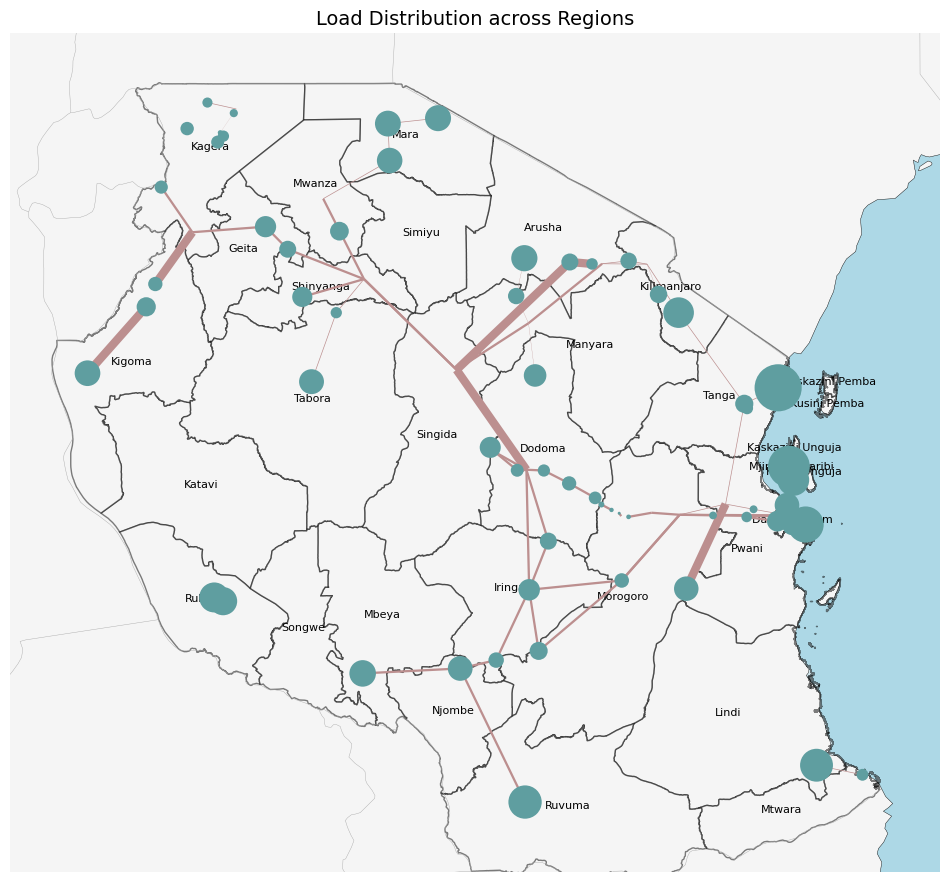

In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# File paths
network = r"C:\Users\hie\pe_tan\pypsa-earth\results\veroni\networks\elec_s_all_ec_lcopt_1h.nc"  #new network
#network=r'C:\Users\hie\pe_tan\pypsa-earth\networks\elec_s_all_ec_lcopt_24h.nc'
gadm_shapefile = r"C:\Users\hie\pe_tan\pypsa-earth\resources\veroni\shapes\gadm_shapes.geojson"  # Path to GADM shapefile

# Load the network
n = pypsa.Network(network)


# Load GADM shapefile
gadm = gpd.read_file(gadm_shapefile)

# Normalize node sizes for plotting
max_node_size = 0.1  # Maximum size of a node for plotting purposes
def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Calculate bus loads
bus_loads = n.loads_t.p_set.sum(axis=0).reindex(n.buses.index, fill_value=0)

# Create the plot
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

# Plot GADM regions as background
gadm.plot(ax=ax, edgecolor="black", facecolor="whitesmoke", alpha=0.5)

# Add region names
for _, row in gadm.iterrows():
    centroid = row["geometry"].centroid
    ax.text(
        centroid.x,
        centroid.y,
        row["NAME_1"],  # Replace "NAME_1" with the appropriate column for region names
        fontsize=8,
        ha="center",
        transform=ccrs.PlateCarree(),
    )

# Plot the network
n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(bus_loads),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",
    transformer_colors="orange",
    line_widths=n.lines.s_nom / 3e2 if "s_nom" in n.lines else None,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)

# Finalize the plot
ax.axis("off")
plt.title("Load Distribution across Regions", fontsize=14)
plt.show()

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


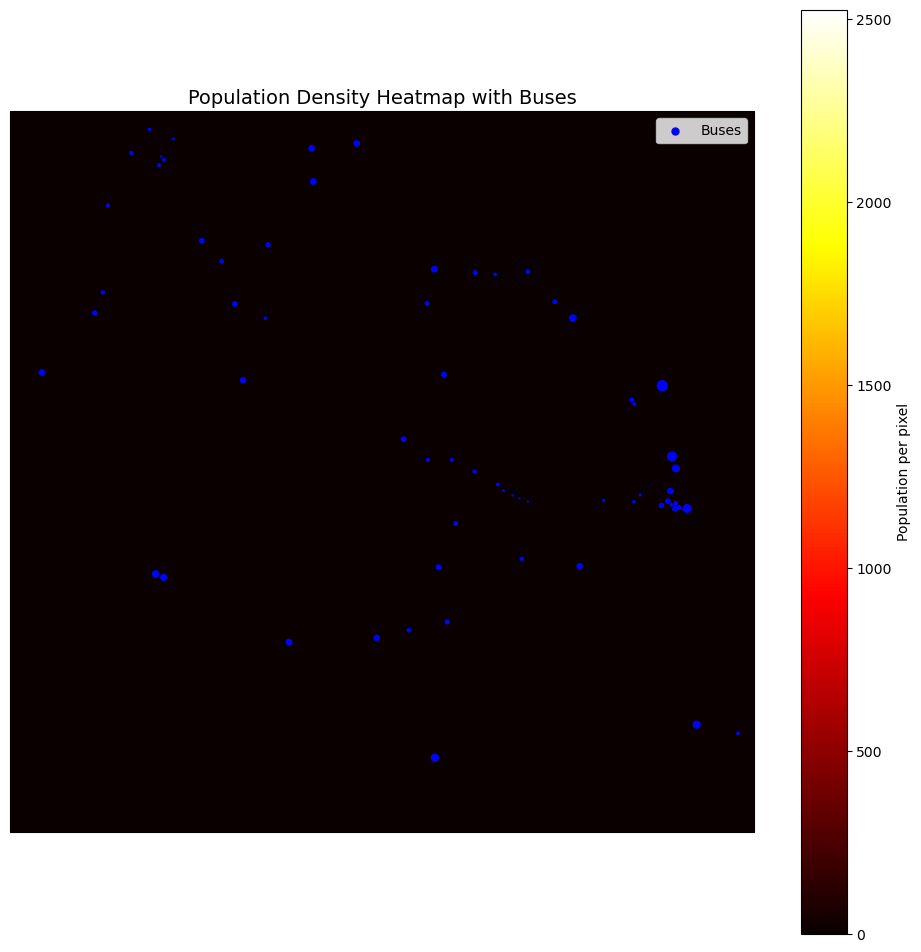

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import pypsa

# File paths
tif_path = r"C:/Users/hie/pe_tan/pypsa-earth/data/WorldPop/tza_ppp_2020_UNadj_constrained.tif"
network_path = r"C:/Users/hie/pe_tan/pypsa-earth/results/veroni/networks/elec_s_all_ec_lcopt_1h.nc"

# Load population density raster
with rasterio.open(tif_path) as src:
    population = src.read(1)  # First (and only) band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Load the PyPSA network
n = pypsa.Network(network_path)

# Normalize node sizes for plotting
def normalize_node_size(values, max_node_size=50):
    return values / values.max() * max_node_size

# Calculate bus loads
bus_loads = n.loads_t.p_set.sum(axis=0).reindex(n.buses.index, fill_value=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the population density heatmap
img = ax.imshow(
    population,
    cmap="hot",  # Heatmap color scheme
    extent=extent,
    norm=Normalize(vmin=0, vmax=population.max()),
    transform=ccrs.PlateCarree(),
)
plt.colorbar(img, ax=ax, label="Population per pixel")

# Overlay the buses
ax.scatter(
    n.buses["x"],
    n.buses["y"],
    color="blue",
    s=normalize_node_size(bus_loads),
    transform=ccrs.PlateCarree(),
    label="Buses",
)

# Finalize the plot
ax.set_title("Population Density Heatmap with Buses", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")
plt.show()

In [ ]:
network = r"C:\Users\hie\pe_tan\pypsa-earth\results\veroni\networks\elec_s_all_ec_lcopt_24h.nc" # change for desired network
#network = r"C:\Users\hie\pe_tan\pypsa-earth\networks\veroni\elec_s_all_ec.nc"
#network=r"C:\Users\hie\pe_tan\pypsa-earth\networks\veroni\elec_s_all_ec_lcopt_24h.nc" #input network
#network=r'C:\Users\hie\pe_tan\pypsa-earth\networks\elec_s_75_ec.nc'
n = pypsa.Network(network)
year=2013
years = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034]

def get_demand(year): 
    network = n[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()


total_demand = [get_demand(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(first_year,final_year)
plt.grid(axis='y')
plt.show()